# Models
This notebook generates all the models required to analyze the movement of the stock market.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score,RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
data = pd.read_pickle('../data/full_data.pkl')
data.head()

,Adj Close,Volume,pct_change_adj_close,lag_pct_change_adj_close,lag_pct_change_volume,lag_ma15_pct_change_adj_close,topic 1,consumption,foreign_exchange_rate,inflation,financial_market,topic 6,sentiment_mc,sentiment_zstc,ffr,unemployment_rate,median_cpi,retail_sales,10_year_treasury_yeild,10year_3month_yield_spread,vix,us_china_exchange_rate,us_japan_exchange_rate,sahm,cpi,inflation_mom,inflation_yoy,real_gdp,gdp_growth_qoq,gdp_growth_yoy,epu_all,epu_news,price_increase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1994-01-03,465.440002,270140000,-0.216531,-0.467310,-13.923210,0.033239,0.041367,0.35654,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,3.15,6.6,2.711772,185142.0,5.75,2.76,12.57,8.7217,112.50,-0.1,146.3,0.205479,2.45098,10195.338,0.970313,3.430523,80.009804,82.292801,0
1994-01-04,466.890015,326600000,0.311536,-0.216531,60.234889,0.022394,0.041367,0.35654,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,3.03,6.6,2.711772,185142.0,5.75,2.73,11.91,8.7217,112.75,-0.1,146.3,0.205479,2.45098,10195.338,0.970313,3.430523,80.009804,82.292801,1
1994-01-05,467.549988,400030000,0.141355,0.311536,20.900274,0.017728,0.041367,0.35654,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,3.46,6.6,2.711772,185142.0,5.75,2.76,10.94,8.7217,113.10,-0.1,146.3,0.205479,2.45098,10195.338,0.970313,3.430523,80.009804,82.292801,1
1994-01-06,467.119995,365960000,-0.091967,0.141355,22.483160,0.064944,0.041367,0.35654,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,3.08,6.6,2.711772,185142.0,5.75,2.72,11.27,8.7217,112.75,-0.1,146.3,0.205479,2.45098,10195.338,0.970313,3.430523,80.009804,82.292801,0
1994-01-07,469.899994,324920000,0.595136,-0.091967,-8.516861,0.076377,0.041367,0.35654,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,2.96,6.6,2.711772,185142.0,5.75,2.63,10.96,8.7117,111.97,-0.1,146.3,0.205479,2.45098,10195.338,0.970313,3.430523,80.009804,82.292801,1


In [5]:
data['price_increase'].value_counts(normalize=True)

price_increase
1    0.538224
0    0.461776
Name: proportion, dtype: float64

## Baseline Model

The baseline accuracy in the sample is 52.8%. The objective of the subsequent models is to achieve higher accuracy and surpass this baseline as much as possible.

### Recurrent Neural Net

The first model trained is an RNN (Recurrent Neural Network). The test set is set at 10 percent of the data, representing approximately the last two years of market data. The data structuring for the RNN model is based on the method employed by this great [blog post](https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn).

In [6]:
train, test = train_test_split(
    data.drop(columns=['Adj Close', 'pct_change_adj_close', 'Volume', 'cpi', 
                       'inflation_mom', 'real_gdp', 'gdp_growth_qoq', 'sahm', 'median_cpi']), 
    shuffle=False, 
    test_size=0.1
)

In [7]:
mm = MinMaxScaler()
# since the labels are binary applying the MinMax scaler would not affet them.
training_set_scaled = mm.fit_transform(train)

In [8]:
len(training_set_scaled)

6698

In [9]:
def rnn_data_structure(data, timesteps=10):
    """
    Prepare the input data and labels for training a Recurrent Neural Network (RNN) model.

    Parameters:
        data (numpy.ndarray): The input data to be preprocessed for the RNN model.
        timesteps (int, optional): The number of time steps to use as input for each sample in the RNN. Default is 10.

    Returns:
        tuple: A tuple containing two numpy arrays - (X, y).
            X (numpy.ndarray): A 3D array of shape (num_samples, timesteps, num_features) representing the input data sequences.
            y (numpy.ndarray): A 1D array of shape (num_samples,) representing the corresponding labels (output values) for each input sequence.
    """

    # Create empty lists to store the input data and corresponding labels
    X = []  # Will store the input data sequences
    y = []  # Will store the labels (output values) corresponding to each input sequence

    # Iterate over the data, starting from the (timesteps - 1)-th element up to the end
    for i in range(timesteps - 1, len(data)):
        # Extract a slice of the input data, from (i - timesteps + 1) to i (inclusive) for each sample
        # Exclude the last element from the slice, as it represents the label
        X.append(data[i - timesteps + 1:i + 1, :-1])

        # Append the last element of the slice (the label) to the y list
        y.append(data[i, -1])

    # Convert the lists X and y into numpy arrays for further processing
    X, y = np.array(X), np.array(y)

    # Return the processed input data (X) and labels (y)
    return X, y


In [10]:
time_steps = 20
X_train, y_train = rnn_data_structure(training_set_scaled, timesteps=time_steps)

In [11]:
test_set_scaled = mm.transform(test)
X_test, y_test = rnn_data_structure(test_set_scaled, timesteps=time_steps)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6679, 20, 23)
(6679,)
(726, 20, 23)
(726,)


In [13]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, X_train.shape[-1])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           77824     
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 162369 (634.25 KB)
Trainable params: 16236

In [15]:
model.compile(loss='bce', optimizer='rmsprop', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
history = model.fit(
    X_train,
    y_train,
    validation_data= (X_test, y_test),
    epochs=20,
    batch_size = 64,
    callbacks = es
)

Epoch 1/20
105/105 [==============================] - 6s 37ms/step - loss: 0.6928 - acc: 0.5345 - val_loss: 0.6933 - val_acc: 0.5124
Epoch 2/20
105/105 [==============================] - 4s 35ms/step - loss: 0.6916 - acc: 0.5351 - val_loss: 0.6950 - val_acc: 0.5124
Epoch 3/20
105/105 [==============================] - 3s 32ms/step - loss: 0.6912 - acc: 0.5415 - val_loss: 0.6913 - val_acc: 0.5386
Epoch 4/20
105/105 [==============================] - 3s 32ms/step - loss: 0.6907 - acc: 0.5372 - val_loss: 0.6949 - val_acc: 0.5124
Epoch 5/20
105/105 [==============================] - 4s 35ms/step - loss: 0.6908 - acc: 0.5363 - val_loss: 0.6954 - val_acc: 0.5124
Epoch 6/20
105/105 [==============================] - 4s 35ms/step - loss: 0.6903 - acc: 0.5383 - val_loss: 0.6927 - val_acc: 0.5124
Epoch 7/20
105/105 [==============================] - 4s 40ms/step - loss: 0.6901 - acc: 0.5404 - val_loss: 0.7010 - val_acc: 0.5124
Epoch 8/20
105/105 [==============================] - 5s 50ms/step - 

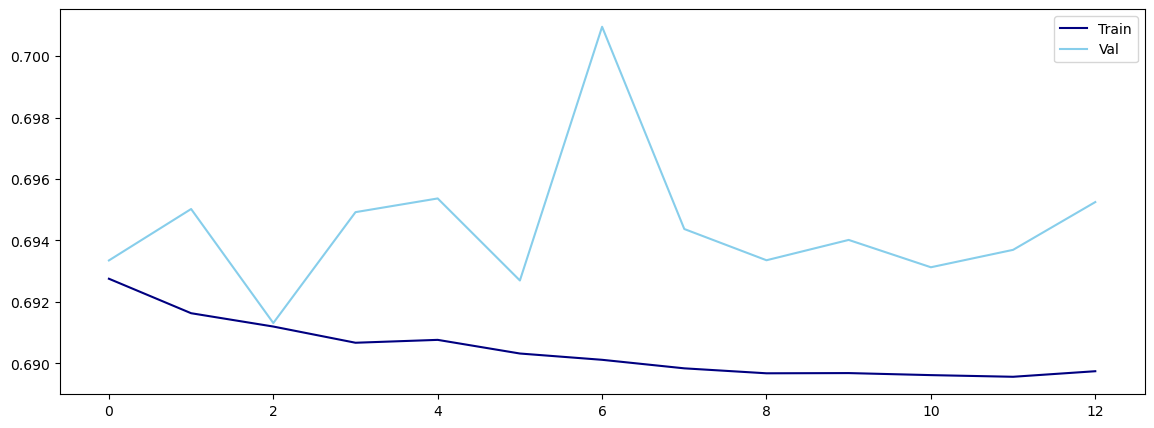

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], c='navy', label='Train')
plt.plot(history.history['val_loss'], c='skyblue', label='Val')
plt.legend();

As evident from the plot, the RNN model is not performing well in making predictions. The validation accuracy remains almost unchanged as the training progresses through new epochs. This suggests that the RNN model is facing challenges in learning meaningful patterns from the data, resulting in limited predictive power. 

In [18]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 6ms/step - loss: 0.6913 - acc: 0.5386


[0.6913117170333862, 0.5385674834251404]

In [19]:
pred_test = model.predict(X_test)

23/23 [==============================] - 1s 5ms/step


In [20]:
pred_test = pred_test.reshape(-1)
pred_test.shape

(726,)

In [ ]:
pred_test = pred_test.reshape(-1)
pred_test.shape

In [22]:
threshold = 0.52
y_pred = np.where(pred_test >= threshold, 1, 0)

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[288  66]
 [296  76]]


              precision    recall  f1-score   support

         0.0       0.49      0.81      0.61       354
         1.0       0.54      0.20      0.30       372

    accuracy                           0.50       726
   macro avg       0.51      0.51      0.45       726
weighted avg       0.51      0.50      0.45       726



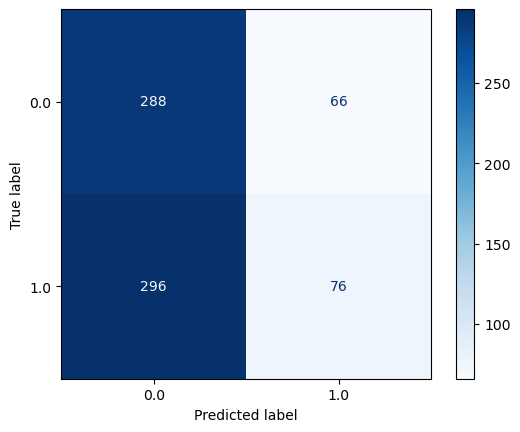

In [24]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues');

Using a threshold of 0.52 may lead to a slight increase in model accuracy. However, it's important to note that this value is arbitrary and should be used with caution. In cases where we expect a 50-50 outcome, fishing for the best threshold is generally not a good practice. We should avoid tuning the threshold arbitrarily as this can lead to an overfit validation set that may not generalize well to unseen data.

Next, I'll prepare the data for other machine learning approaches. 

In [25]:
X = data.drop(columns=['Adj Close', 'pct_change_adj_close', 'Volume', 'cpi', 
                       'inflation_mom', 'real_gdp', 'gdp_growth_qoq', 'sahm', 'median_cpi', 'price_increase'])

y = data['price_increase']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape)

(6698, 23) (745, 23)


In [235]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [236]:
# hyperparameters of logistic regression

logreg_params = {
    'penalty':[None, 'l1', 'l2'], 
    'C': np.linspace(0.01, 1, 50),
}

In [237]:
# hyperparameters of random forest estimator

rf_params = {
    'n_estimators': [100, 150, 175, 200, 225, 250],
    'max_depth': [None, 3, 5, 10, 20, 40, 60, 80, 100],
    'min_samples_split': np.arange(1, 20, 1)
}

In [238]:
# hyperparameters of support vector classifier
svc_params={'C': np.linspace(0.01, 4, 50),
            'kernel': ['rbf','poly', 'linear'], 
            'degree' : [2,3,4]
           }

In [239]:
# hyperparameters of gradient boosting classifier
gb_params = {
    'learning_rate': [0.1, 0.5, 1, 1.025, 1.05, 1.075, 1.1],
    'n_estimators': [100, 125, 150, 170, 175, 180, 185],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': np.append(None, np.arange(1, 21, 2))
}

In [240]:
model_dict = {
              'logreg': {'mod_instant': LogisticRegression(solver='liblinear', max_iter= 5000), 'mod_param':logreg_params},
              'rf': {'mod_instant': RandomForestClassifier(random_state= 42), 'mod_param':rf_params},
              'svc':{'mod_instant': SVC(probability=True), 'mod_param': svc_params},
              'gb': {'mod_instant': GradientBoostingClassifier(random_state= 42), 'mod_param':gb_params}           
             }

In [241]:
def random_search_modeler(model, cross_validation=5, model_params=None, random_state=42, num_iter=30):
    """
    Perform hyperparameter tuning using Randomized Search Cross-Validation for a given model.

    Parameters:
        model: The machine learning model to be tuned.
        cross_validation (int, optional): Number of cross-validation folds. Default is 5.
        model_params (dict, optional): Dictionary of hyperparameter ranges for the model. Default is None.
        random_state (int, optional): Random seed for reproducibility. Default is 42.
        num_iter (int, optional): Number of iterations for random search. Default is 20.

    Returns:
        RandomizedSearchCV: A RandomizedSearchCV object with the specified model, hyperparameter ranges, and cross-validation settings.
    """

    # Create a Pipeline with the given model
    pipe = Pipeline([
        ('model', model)
    ])

    # Create an empty dictionary to store hyperparameter ranges in the format expected by RandomizedSearchCV
    pgrids = {}

    # Check if model_params is provided, if yes, update the pgrids dictionary with the specified hyperparameter ranges
    if model_params:
        for key, val in model_params.items():
            pgrids[f"model__{key}"] = val

    # Initialize RandomizedSearchCV with the pipeline, hyperparameter ranges, and other specified settings
    rs = RandomizedSearchCV(pipe, param_distributions=pgrids, cv=cross_validation, random_state=random_state, n_iter=num_iter)

    # Return the RandomizedSearchCV object for further use (fitting and evaluation)
    return rs

In [35]:
%%time 
models = {}

# Iterate over each key-value pair in the model_dict dictionary
for key, dic in model_dict.items():
    # Create an instance of the random_search_modeler function
    # with the specified model, cross-validation strategy, and model parameters
    model = random_search_modeler(dic['mod_instant'], 
                                    cross_validation=kf, 
                                    model_params=dic['mod_param']
                                 )
    
    # Fit the random_search_modeler object to the training data
    model.fit(X_train, y_train)
    print(f"{dic['mod_instant']} successfully completed.")
    
    # Assign the fitted model to the models dictionary using the corresponding key
    models[key] = model

LogisticRegression(max_iter=5000, solver='liblinear') successfully completed.
RandomForestClassifier(random_state=42) successfully completed.
SVC(probability=True) successfully completed.
GradientBoostingClassifier(random_state=42) successfully completed.
CPU times: user 18min 1s, sys: 25.4 s, total: 18min 26s
Wall time: 19min 25s


In [36]:
for model in ['logreg', 'rf', 'svc', 'gb']:

    print(f"{model} model - Train Accuracy:", models[model].score(X_train, y_train))
    print(f"{model} model - Validation Accuracy:", models[model].score(X_test, y_test))
    print(f"{model} model - Validation AUC:", roc_auc_score(y_test, models[model].predict_proba(X_test)[:, 1]))
    print('\n')
    print(classification_report(y_test, models[model].predict(X_test)))
    print('\n')

logreg model - Train Accuracy: 0.5810689758136757
logreg model - Validation Accuracy: 0.5315436241610738
logreg model - Validation AUC: 0.6207864357864359


              precision    recall  f1-score   support

           0       0.51      0.85      0.64       360
           1       0.62      0.23      0.34       385

    accuracy                           0.53       745
   macro avg       0.57      0.54      0.49       745
weighted avg       0.57      0.53      0.48       745



rf model - Train Accuracy: 0.9562555986861749
rf model - Validation Accuracy: 0.5583892617449664
rf model - Validation AUC: 0.5897041847041846


              precision    recall  f1-score   support

           0       0.54      0.64      0.58       360
           1       0.59      0.49      0.53       385

    accuracy                           0.56       745
   macro avg       0.56      0.56      0.56       745
weighted avg       0.56      0.56      0.56       745



svc model - Train Accuracy: 0.6914004180

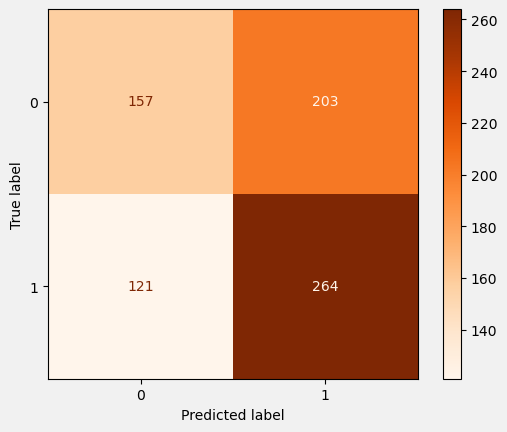

In [39]:
ConfusionMatrixDisplay.from_estimator(models['gb'], X_test, y_test, cmap='Blues')
plt.show()

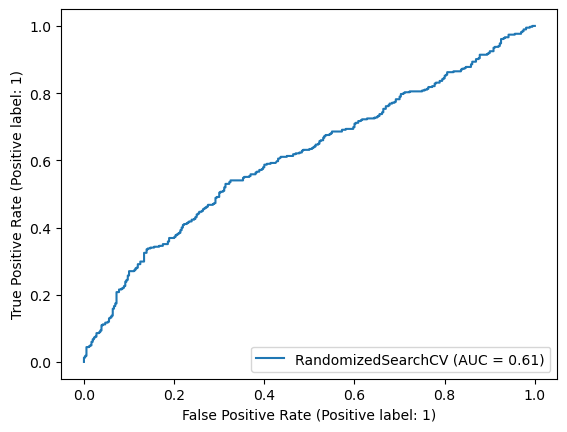

In [40]:
RocCurveDisplay.from_estimator(models['gb'], X_test, y_test)

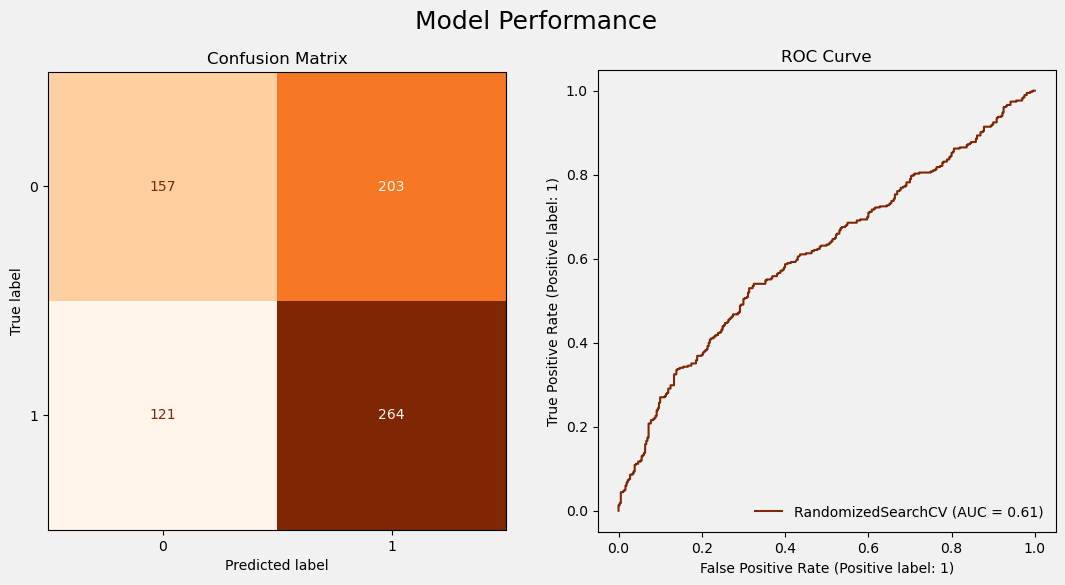

In [54]:
color = "#F1F1F1"

# sns.set_style('white')
plt.rcParams["figure.facecolor"] = color

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ConfusionMatrixDisplay.from_estimator(models['gb'], X_test, y_test, cmap='Oranges', colorbar=False, ax=ax[0])
RocCurveDisplay.from_estimator(models['gb'], X_test, y_test, ax=ax[1], color ='#7F2704')

ax[0].set_title('Confusion Matrix')
ax[1].set_title('ROC Curve')

ax[0].set_facecolor(color)
ax[1].set_facecolor(color)

fig.suptitle('Model Performance', fontsize=18)

ax[1].legend(frameon=False, loc='lower right')

plt.savefig('../images/model_performance.png', dpi=300);

### Analysing Weekly data:
Up until now, the discussion has primarily relied on daily data for all variables. However, a challenge arises due to the mixed frequencies of the data and the fact that many predictors have monthly (or even slower) frequencies. This situation leads to repeated values over time for such variables.

To address this issue, the data is transformed from daily to weekly, which helps mitigate the problem of excessive repetitions. With the data now in a weekly format, the models are reintroduced to this updated dataset for further analysis, aiming to predict weekly changes in the stock market.

In [260]:
import pandas as pd
import numpy as np

# Create an empty DataFrame
df = pd.DataFrame()

# Extract the 'Adj Close' column from the 'data' DataFrame and resample it to weekly frequency, taking the last value of each week.
df['close'] = data['Adj Close'].resample('W').last()

# Calculate the percentage change of the 'close' column to get weekly percentage changes in stock prices.
df['pct_change_close'] = df['close'].pct_change()

# Create a new column 'pct_change_close_lag' containing the previous week's percentage change values.
df['pct_change_close_lag'] = df['pct_change_close'].shift()

# Extract specific columns from 'data' DataFrame related to economic indicators, and resample them to weekly frequency, taking the last value of each week.
df1 = data[
    ['Volume', 'ffr', 'unemployment_rate', 'retail_sales', '10_year_treasury_yeild', '10year_3month_yield_spread',
     'vix', 'us_china_exchange_rate', 'us_japan_exchange_rate', 'inflation_yoy', 'gdp_growth_yoy', 'epu_all']
].resample('W').last()

# Calculate the percentage change of the 'Volume' column to get weekly percentage changes in trading volume.
df1['pct_change_vol_lag'] = df1['Volume'].pct_change()

# Shift the 'df1' DataFrame by one week, aligning the economic indicators with the corresponding stock market data for prediction purposes.
df1 = df1.shift()

# Combine the 'df' DataFrame containing stock market data with the 'df1' DataFrame containing economic indicators data.
df = pd.concat([df, df1], axis=1)

# Extract specific columns from the 'data' DataFrame related to other topics, and resample them to weekly frequency, taking the last value of each week.
df2 = data[['topic 1', 'consumption', 'foreign_exchange_rate', 'inflation', 'financial_market', 'topic 6',
            'sentiment_mc', 'sentiment_zstc']].resample('W').last()

# Shift the 'df2' DataFrame by one week, aligning the other topics data with the corresponding stock market data for prediction purposes.
df2 = df2.shift()

# Combine the 'df' DataFrame containing stock market and economic indicators data with the 'df2' DataFrame containing other topics data.
df = pd.concat([df, df2], axis=1)

# Create a new column 'price_increase' that is 1 if the weekly percentage change in stock prices is greater than or equal to 0, otherwise 0.
df['price_increase'] = np.where(df['pct_change_close'] >= 0, 1, 0)

# Drop the 'close', 'Volume', and 'pct_change_close' columns as they are no longer needed for prediction.
df.drop(columns=['close', 'Volume', 'pct_change_close'], inplace=True)

# Drop any rows with missing values (NaN) in the DataFrame.
df.dropna(inplace=True)

# Display the first few rows of the final DataFrame 'df'.
df.head()


,pct_change_close_lag,ffr,unemployment_rate,retail_sales,10_year_treasury_yeild,10year_3month_yield_spread,vix,us_china_exchange_rate,us_japan_exchange_rate,inflation_yoy,gdp_growth_yoy,epu_all,pct_change_vol_lag,topic 1,consumption,foreign_exchange_rate,inflation,financial_market,topic 6,sentiment_mc,sentiment_zstc,price_increase
Date,,,,,,,,,,,,,,,,,,,,,,
1994-01-23,0.010662,2.95,6.6,185142.0,5.75,2.75,11.15,8.7217,111.24,2.450980,3.430523,80.009804,-0.061554,0.041367,0.356540,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,0
1994-01-30,-0.000400,2.91,6.6,185142.0,5.75,2.72,11.09,8.7257,111.25,2.450980,3.430523,80.009804,0.135872,0.041367,0.356540,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,1
1994-02-06,0.008384,2.98,6.6,185142.0,5.75,2.69,9.94,8.7217,109.45,2.450980,3.430523,80.009804,-0.095886,0.041367,0.356540,0.071715,0.404525,0.041951,0.083903,3.265306,0.692368,0
1994-02-13,-0.018571,3.19,6.6,188074.0,5.97,2.64,15.25,8.7228,108.98,2.515723,3.430523,94.592697,0.208341,0.233732,0.287235,0.056753,0.312348,0.050946,0.058986,2.780331,0.639252,1
1994-02-20,0.000788,3.14,6.6,188074.0,5.97,2.55,14.46,8.7292,107.67,2.515723,3.430523,94.592697,-0.435118,0.233732,0.287235,0.056753,0.312348,0.050946,0.058986,2.780331,0.639252,0


The baseline for model performance in this new setting increases to 56% 

In [283]:
df['price_increase'].value_counts(normalize=True)

price_increase
1    0.564568
0    0.435432
Name: proportion, dtype: float64

#### RNN

In [261]:
train, test = train_test_split(
    df,
    shuffle=False, 
    test_size=0.1
)

In [262]:
mm = MinMaxScaler()
training_set_scaled = mm.fit_transform(train)
test_set_scaled = mm.transform(test)

time_steps = 5
X_train, y_train = rnn_data_structure(training_set_scaled, timesteps=time_steps)
X_test, y_test = rnn_data_structure(test_set_scaled, timesteps=time_steps)

In [263]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1382, 5, 21)
(1382,)
(151, 5, 21)
(151,)


In [284]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, X_train.shape[-1])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='bce', optimizer='rmsprop', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data= (X_test, y_test),
    epochs=100,
    batch_size = 64,
    callbacks = es, 
    verbose=0
)

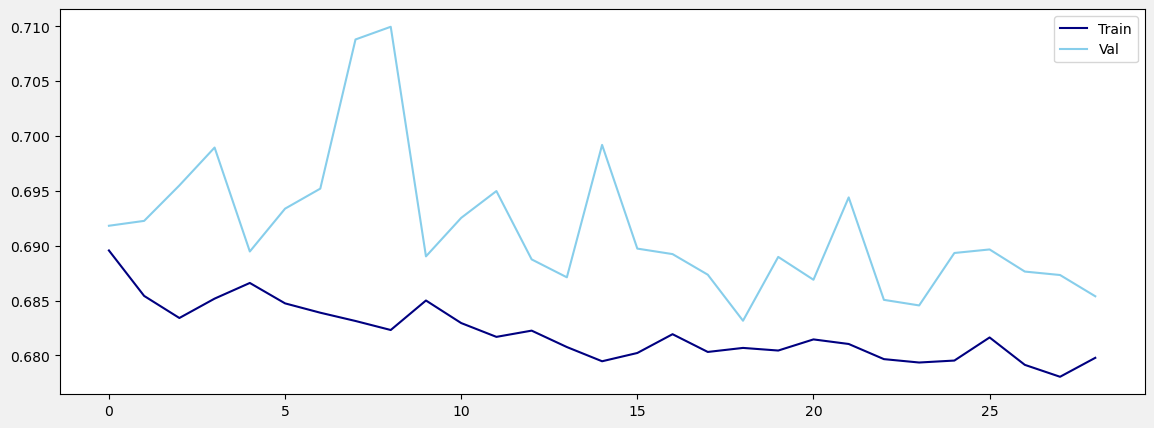

In [265]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], c='navy', label='Train')
plt.plot(history.history['val_loss'], c='skyblue', label='Val')
plt.legend();

In [285]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 12ms/step - loss: 0.6793 - acc: 0.5894


[0.6793233752250671, 0.5894039869308472]

In [267]:
pred_test = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [268]:
pred_test = pred_test.reshape(-1)
pred_test.shape

(151,)

In [269]:
print(pred_test.min())
print(pred_test.max())


0.38725376
0.63959295


In [270]:
threshold = 0.5
y_pred = np.where(pred_test >= threshold, 1, 0)


In [271]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[28 42]
 [20 61]]


              precision    recall  f1-score   support

         0.0       0.58      0.40      0.47        70
         1.0       0.59      0.75      0.66        81

    accuracy                           0.59       151
   macro avg       0.59      0.58      0.57       151
weighted avg       0.59      0.59      0.58       151



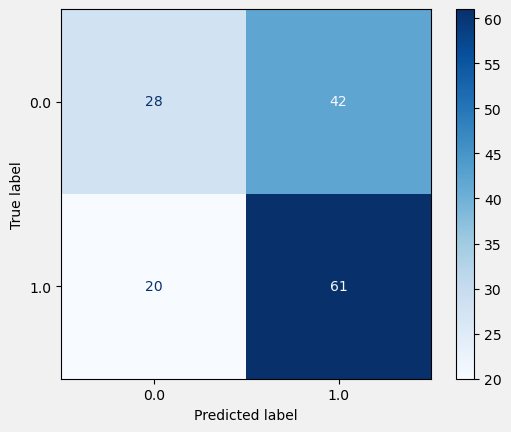

In [272]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues');

#### Machine learning algorithms

In [273]:
X = df.drop(columns=['price_increase'])

y = df['price_increase']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape)

(1386, 21) (155, 21)


In [274]:
%%time 
models = {}

for key, dic in model_dict.items():

    model = random_search_modeler(dic['mod_instant'], 
                                    cross_validation=kf, 
                                    model_params=dic['mod_param']
                                 )  
    model.fit(X_train, y_train)
    print(f"{dic['mod_instant']} successfully completed.")
    
    models[key] = model

LogisticRegression(max_iter=5000, solver='liblinear') successfully completed.
RandomForestClassifier(random_state=42) successfully completed.
SVC(probability=True) successfully completed.
GradientBoostingClassifier(random_state=42) successfully completed.
CPU times: user 2min 1s, sys: 1.58 s, total: 2min 3s
Wall time: 2min 11s


In [275]:
for model in ['logreg', 'rf', 'svc', 'gb']:

    print(f"{model} model - Train Accuracy:", models[model].score(X_train, y_train))
    print(f"{model} model - Validation Accuracy:", models[model].score(X_test, y_test))
    print(f"{model} model - Validation AUC:", roc_auc_score(y_test, models[model].predict_proba(X_test)[:, 1]))
    print('\n')
    print(classification_report(y_test, models[model].predict(X_test)))
    print('\n')

logreg model - Train Accuracy: 0.5887445887445888
logreg model - Validation Accuracy: 0.6129032258064516
logreg model - Validation AUC: 0.6222334004024146


              precision    recall  f1-score   support

           0       0.60      0.48      0.53        71
           1       0.62      0.73      0.67        84

    accuracy                           0.61       155
   macro avg       0.61      0.60      0.60       155
weighted avg       0.61      0.61      0.61       155



rf model - Train Accuracy: 0.6060606060606061
rf model - Validation Accuracy: 0.5548387096774193
rf model - Validation AUC: 0.5352112676056338


              precision    recall  f1-score   support

           0       0.62      0.07      0.13        71
           1       0.55      0.96      0.70        84

    accuracy                           0.55       155
   macro avg       0.59      0.52      0.41       155
weighted avg       0.58      0.55      0.44       155



svc model - Train Accuracy: 0.6428571428

### What is the impact of FOMC
In this section, the data created from the FOMC meetings are removed from the sample, to analyze their role in predicting changes in stock market prices. 

#### RNN

In [ ]:
train, test = train_test_split(
    df.drop(columns=['topic 1',
       'consumption', 'foreign_exchange_rate', 'inflation', 'financial_market',
       'topic 6', 'sentiment_mc', 'sentiment_zstc']),
    shuffle=False, 
    test_size=0.1
)

mm = MinMaxScaler()
training_set_scaled = mm.fit_transform(train)
test_set_scaled = mm.transform(test)

time_steps = 5
X_train, y_train = rnn_data_structure(training_set_scaled, timesteps=time_steps)

X_test, y_test = rnn_data_structure(test_set_scaled, timesteps=time_steps)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, X_train.shape[-1])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='bce', optimizer='rmsprop', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data= (X_test, y_test),
    epochs=100,
    batch_size = 64,
    callbacks = es,
    verbose=0
)
model.evaluate(X_test, y_test)
pred_test = model.predict(X_test)
pred_test = pred_test.reshape(-1)
pred_test.shape
threshold = 0.5
y_pred = np.where(pred_test >= threshold, 1, 0)
print(pred_test.min())
print(pred_test.max())
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues');

# Machine learning methods

In [276]:
X = df.drop(columns=['price_increase', 'topic 1',
       'consumption', 'foreign_exchange_rate', 'inflation', 'financial_market',
       'topic 6', 'sentiment_mc', 'sentiment_zstc'])

y = df['price_increase']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape)

(1386, 13) (155, 13)


In [277]:
models = {}

for key, dic in model_dict.items():
    model = random_search_modeler(dic['mod_instant'], 
                                    cross_validation=kf, 
                                    model_params=dic['mod_param']
                                 )
    
    model.fit(X_train, y_train)
    print(f"{dic['mod_instant']} successfully completed.")
    
    models[key] = model

LogisticRegression(max_iter=5000, solver='liblinear') successfully completed.
RandomForestClassifier(random_state=42) successfully completed.
SVC(probability=True) successfully completed.
GradientBoostingClassifier(random_state=42) successfully completed.


In [278]:
for model in ['logreg', 'rf', 'svc', 'gb']:

    print(f"{model} model - Train Accuracy:", models[model].score(X_train, y_train))
    print(f"{model} model - Validation Accuracy:", models[model].score(X_test, y_test))
    print(f"{model} model - Validation AUC:", roc_auc_score(y_test, models[model].predict_proba(X_test)[:, 1]))
    print('\n')
    print(classification_report(y_test, models[model].predict(X_test)))
    print('\n')

logreg model - Train Accuracy: 0.5800865800865801
logreg model - Validation Accuracy: 0.6
logreg model - Validation AUC: 0.6210596914822266


              precision    recall  f1-score   support

           0       0.56      0.63      0.59        71
           1       0.65      0.57      0.61        84

    accuracy                           0.60       155
   macro avg       0.60      0.60      0.60       155
weighted avg       0.61      0.60      0.60       155



rf model - Train Accuracy: 0.6046176046176046
rf model - Validation Accuracy: 0.535483870967742
rf model - Validation AUC: 0.567739771965124


              precision    recall  f1-score   support

           0       0.49      0.34      0.40        71
           1       0.56      0.70      0.62        84

    accuracy                           0.54       155
   macro avg       0.52      0.52      0.51       155
weighted avg       0.53      0.54      0.52       155



svc model - Train Accuracy: 0.5670995670995671
svc model 

Upon removing this specific set of variables, the overall accuracy of all models experiences a marginal decline of approximately 1 percent. Though the decrease in performance is small, it is worth noting that the models had exhibited only minimal improvement over the baseline initially.